# Create Distance Infographic - Cosmic Explorer Trade Study 

This Notebook reads from the output of Bayesian inference runs and creates a distance infographic for measuring the parameters of a CBC signal to within 10% accuracy.

### Import modules

In [1]:
import numpy
import matplotlib.pyplot as plt
import json
from matplotlib.patches import Patch
import seaborn as sns
from glob import glob
import collections
import math
import matplotlib.patches as mpatches

# plt.style.use('dark_background')
%matplotlib inline


In [2]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [3]:
sns.color_palette("muted", 20)

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215),
 (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

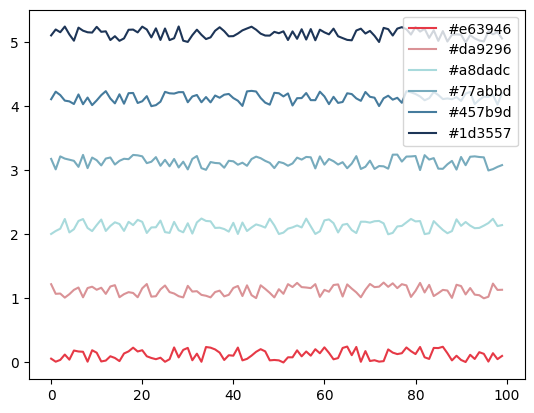

In [4]:
c_palette_list = ['#e63946', '#da9296', '#a8dadc', '#77abbd', '#457b9d', '#1d3557']
x = numpy.array(range(100)) 
for ii in range(len(c_palette_list)):
    plt.plot(x, ii + numpy.random.rand(100)*0.25, 
             color=c_palette_list[ii], label=c_palette_list[ii])
plt.legend()

In [5]:
# sns.palplot(sns.light_palette("orange", 4))
# palette = sns.color_palette("Blues_r", 4)
# palette = sns.color_palette("hls", 8)


# define a dictionary to standardize the colors for different detectors


# color_dict = {'CE-40':palette[4], 'CE-20':palette[5], 
#               'A#':palette[6], 'A#':palette[6],
#               'CE-40 + CE-20':palette[2], 
#               'LVK':palette[0], 'aLIGO':palette[0], 
#               '1-XG':palette[1], '2-XG':palette[2], '3-XG':palette[3],}

color_dict = {'A# (HLI)':c_palette_list[0], 
              'CE-20':c_palette_list[1], 
              'CE-40':c_palette_list[3],
#               'CE-40 + A#':c_palette_list[2],
              'CE-40 + CE-20':c_palette_list[4],
              'CE-40 + CE-40':c_palette_list[5]}

label_dict = {"NS-radius": r"Constrain NS radius to within 50 m",
              "sky-loc": r"Locate 100 sources to within 10 sq. deg.",
              "early-detection": r"Detect $100$ sources 5 mins before merger",
              "H0": r"Measure $H_0$ to within $1\%$",
              "Omega": r"Measure $\Omega_m$ to within $1\%$",
              "GR": r"Precision measurement of GR",
              "BH-mass-spectrum": r"Measure BH mass spectrum",
              "NS-mass-spectrum": r"Measure NS mass spectrum",
             }

In [6]:
def plot_dist_bar(network_dict, nw_number):
    '''
    Evaluates the x-ranges for the broken bar for
    each parameter from the dictionary values. Plots 
    the broken bars for each parameter.
    
    Parameters
    ----------
    network_dict: dictionary
        Dictionary with the disctance values
    
    nw_number: int
        Number id for the detctor network
    '''
    
    sorted_dict = {x: network_dict[x] for x in network_dict if x not in ["Name"]}
    sorted_dict = collections.OrderedDict(sorted(sorted_dict.items(), key=lambda x: x[1], reverse=True))
    if network_dict["Name"]=="sky-loc":
        for key in sorted_dict.keys():
            if sorted_dict[key]!= 0:
                p = ax.barh(10*nw_number, sorted_dict[key], left=0, height = 5, 
                            color=color_dict[key], alpha = 1)
    else:    
        for key in sorted_dict.keys():
            if sorted_dict[key]!= 0:
                p = ax.barh(10*nw_number, sorted_dict[key], left=0, height = 5, 
                            color=color_dict[key], alpha = 1)
    

#     p = ax.barh(10*nw_number, network_dict['LVK'], left=0, height = 5, 
#                 color=color_dict['LVK'], alpha = 1, label=str(int(network_dict['LVK']))) 

#     p = ax.barh(10*nw_number, network_dict['CE-20'], left=0, height = 5, 
#                 color=color_dict['CE-20'], alpha = 1, label=str(int(network_dict['CE-20'])))
    
#     p = ax.barh(10*nw_number, network_dict['CE-40'], left=0, height = 5, 
#                 color=color_dict['CE-40'], alpha = 1., label=str(int(network_dict['CE-40'])))


#     p = ax.barh(10*nw_number, network_dict['CE-40 + CE-20'], left=0, height = 5, 
#                 color=color_dict['CE-40 + CE-20'], alpha = 1, label=str(int(network_dict['CE-40 + CE-20']))) 
  

### Data 

In [7]:
color_dict.keys()

dict_keys(['A# (HLI)', 'CE-20', 'CE-40', 'CE-40 + CE-20', 'CE-40 + CE-40'])

In [8]:
input_data = [
{"Name": "NS-radius", "A# (HLI)": 25, "CE-20": 1, "CE-40": 0.2, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0.15, "CE-40 + CE-40": 0},

# Sky localizationa nd eraly detection data taken from 
# Fig 1 and Fig 4 of https://iopscience.iop.org/article/10.3847/2041-8213/ac1a75/pdf
{"Name": "sky-loc", "A# (HLI)": 11, "CE-20": 0, "CE-40": 0, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 1},
    
{"Name": "early-detection", "A# (HLI)": 33, "CE-20": 0, "CE-40": 1, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 0.5},
    
# {"Name": "sky-loc", "3-XG": 2, "2-XG": 16, "1-XG": 1000},
# {"Name": "early-detection", "3-XG": 0.5, "2-XG": 4, "1-XG": 10},

# Cosmological measurement data is taken from Table 1 of https://arxiv.org/pdf/2011.01211.pdf and
# from https://arxiv.org/pdf/1712.06531.pdf
{"Name": "H0", "A# (HLI)": 8, "CE-20": 0, "CE-40": 1, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 0},
    
{"Name": "Omega", "A# (HLI)": 10, "CE-20": 0, "CE-40": 2, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 0},    
    
# Waiting for Table 2 to be filled in to get the data for the following three science goals
{"Name": "GR", "A# (HLI)": 33, "CE-20": 0, "CE-40": 1, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 0.5},
    
{"Name": "BH-mass-spectrum", "A# (HLI)": 33, "CE-20": 0, "CE-40": 1, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 0.5},
    
    {"Name": "NS-mass-spectrum", "A# (HLI)": 33, "CE-20": 0, "CE-40": 1, 
 "CE-40 + A# (HLI)": 0, "CE-40 + CE-20": 0, "CE-40 + CE-40": 0.5},

# {"Name": "GR", "CE-40": 1, "CE-20": 0, "A# (HLI)": 2, "LVK": 70},
# {"Name": "BH-mass-spectrum", "CE-40": 2, "CE-20": 20, "CE-40 + CE-20": 1, "LVK": 100},
# {"Name": "NS-mass-spectrum", "CE-40": 2, "CE-20": 20, "CE-40 + CE-20":1, "LVK": 100}
]

### Plotting the timelines

plotting times for NS-mass-spectrum
plotting times for BH-mass-spectrum
plotting times for GR
plotting times for Omega
plotting times for H0
plotting times for early-detection
plotting times for sky-loc
plotting times for NS-radius
[<matplotlib.patches.Patch object at 0x7f4874458df0>, <matplotlib.patches.Patch object at 0x7f48743d2430>, <matplotlib.patches.Patch object at 0x7f48743d2670>, <matplotlib.patches.Patch object at 0x7f48743d26d0>, <matplotlib.patches.Patch object at 0x7f48743d2730>, <matplotlib.patches.Patch object at 0x7f4875cb23a0>]


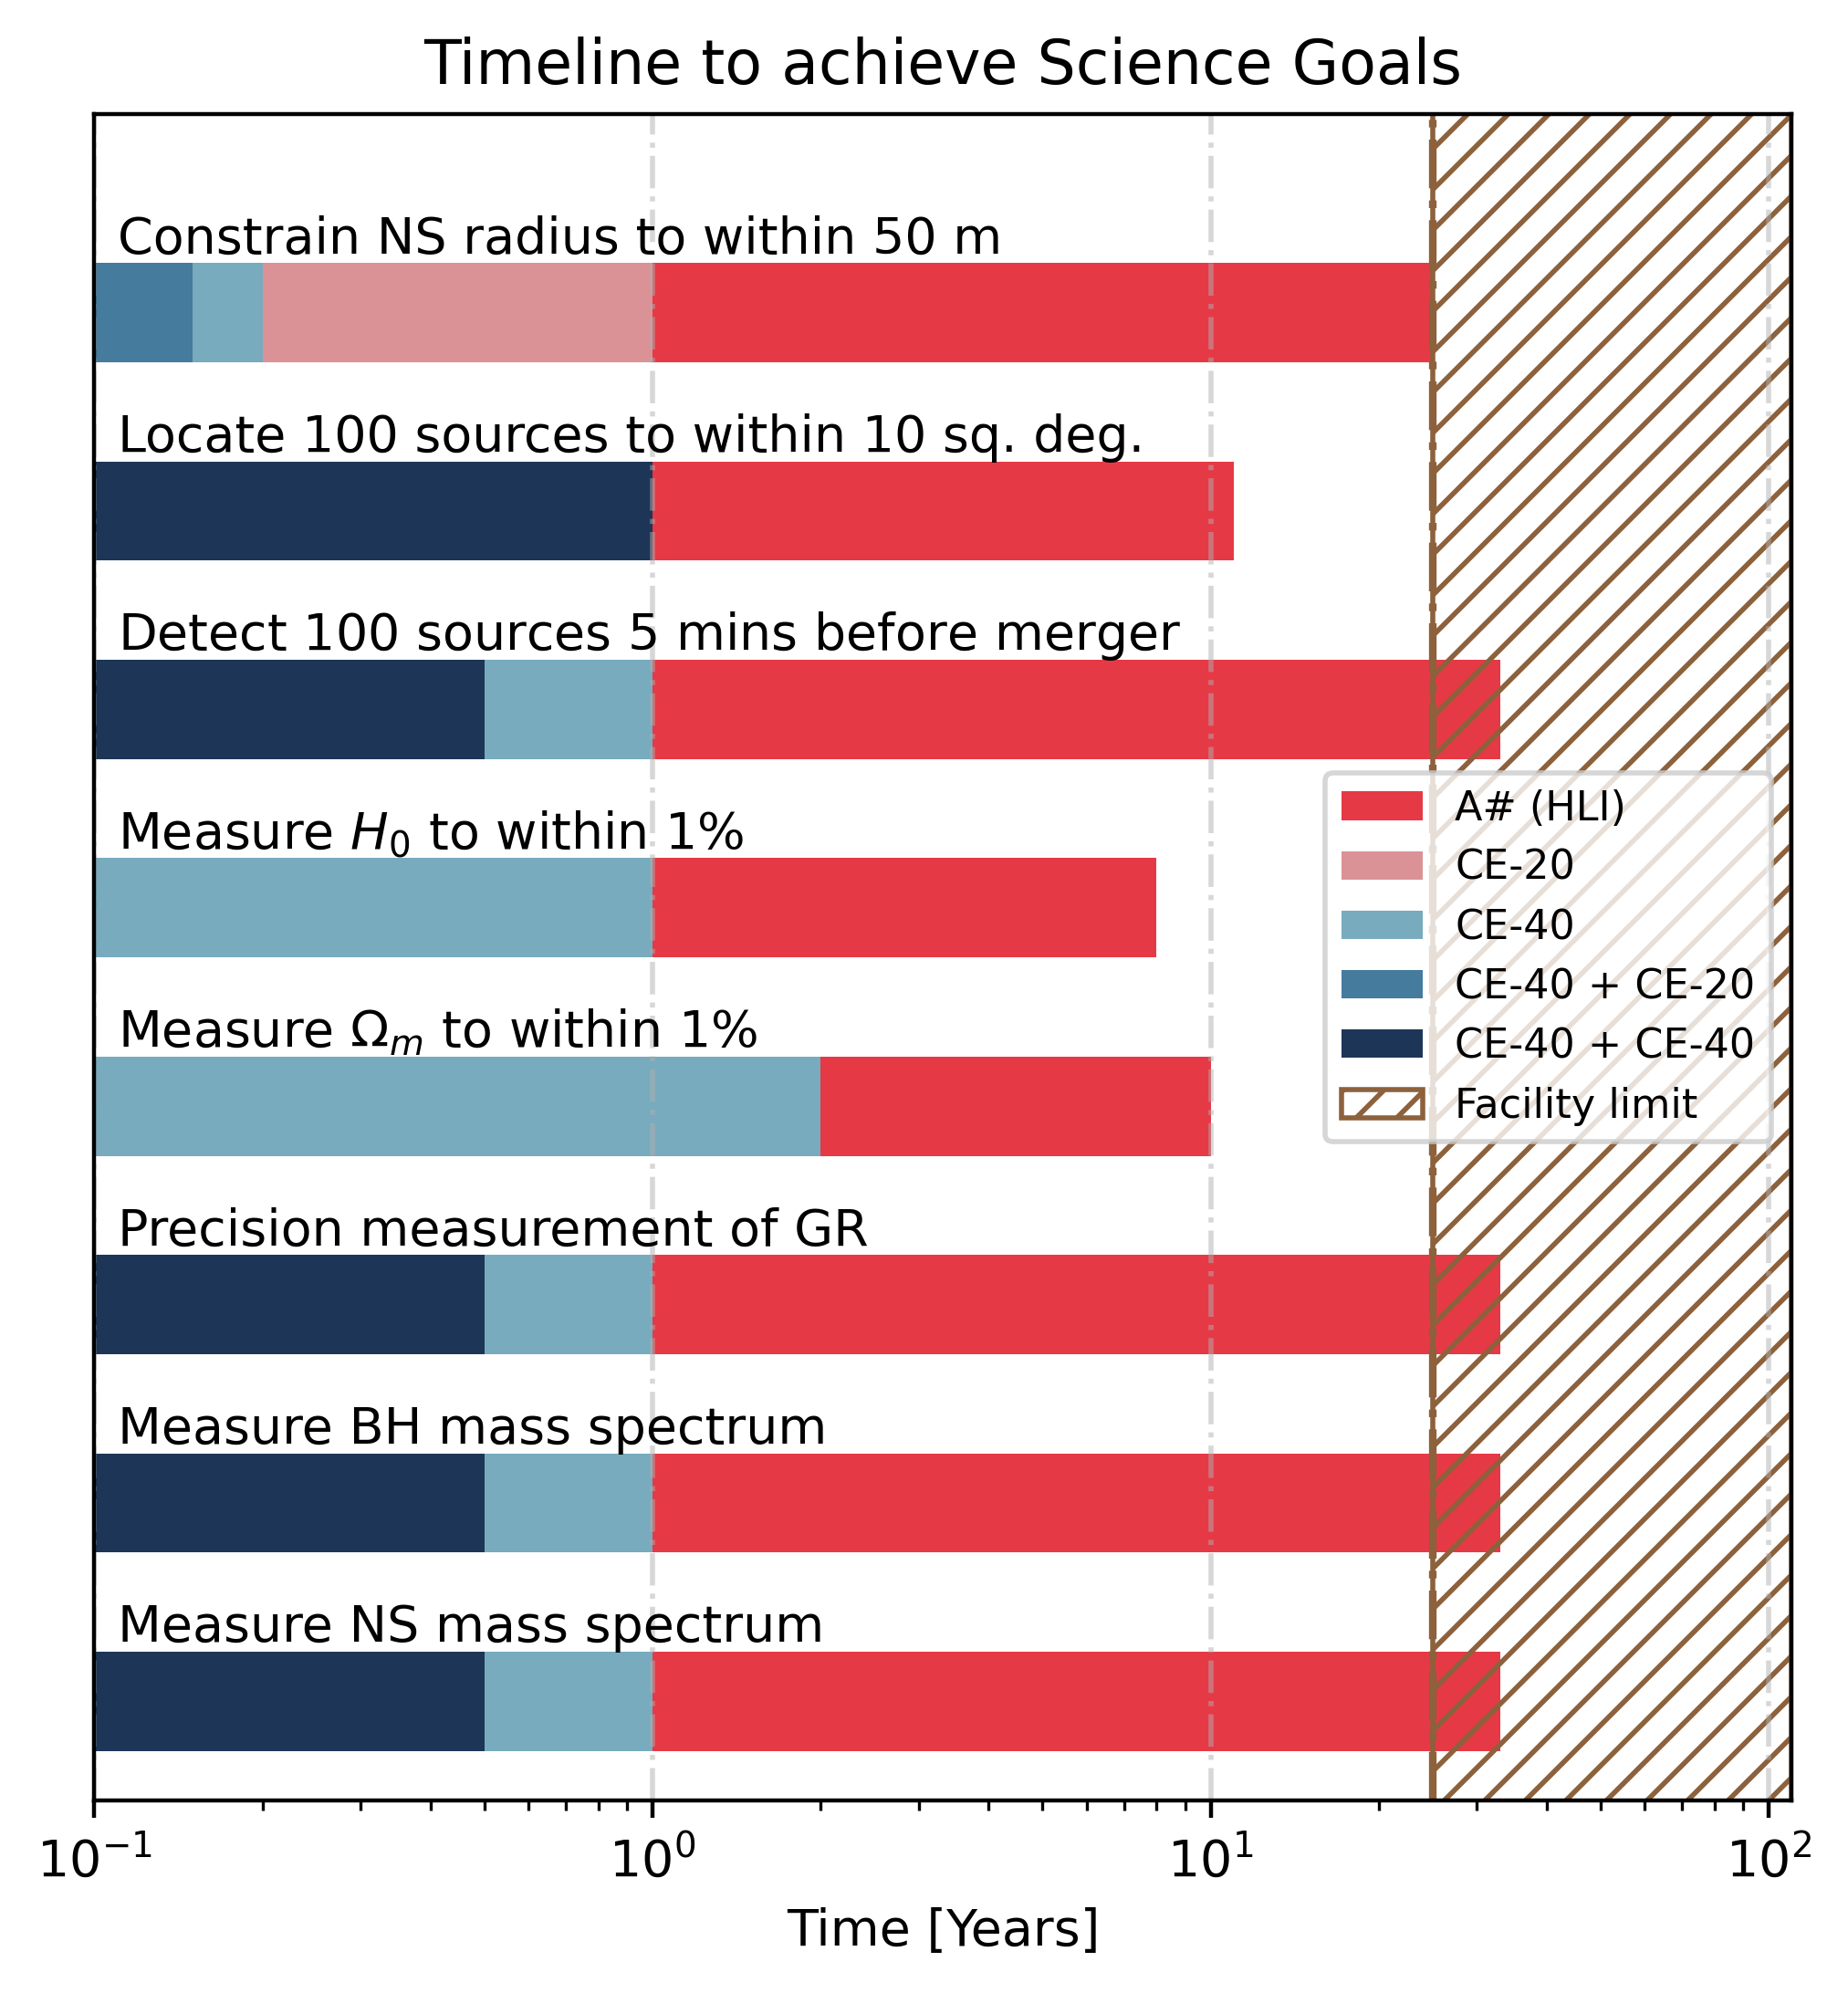

In [9]:
# list of all the network files
network_list = sorted(glob("timeline_plot_data/timeline_plot_data.txt"), reverse=True)

# example contents of a file:
# {"Name": "Time to constrain NS radius to within 10", "CE-40": 2, "CE-20": 20, "CE-40 + CE-20": 1, "LVK": 100}

# initiate a list of names for the detector networks
name_list = []

fig, ax = plt.subplots(figsize=[6, 6], dpi=400)

# with open(network_list[0], 'r') as handle:
#     input_data = [json.loads(line) for line in handle]
    
for ii in range(len(input_data)):
#     print(input_data[-ii])
    nw_dict = input_data[-ii-1]
    name = nw_dict['Name']
    print('plotting times for {}'.format(name))
    name_list.append(name)
    plot_dist_bar(nw_dict, ii+1)
    plt.text(0.11, 3+(10*(ii+1)), label_dict[name])

ax.set_ylim(5, len(input_data)*10+10)

ax.set_xlabel('Time [Years]')
ax.set_xticks([.1, 1, 10, 100])
ax.set_yticks([])
# ax.set_yticks([(ii*10 +10) for ii in range(len(input_data))], 
#               labels=name_list)     # Modify y-axis tick labels
# ax.grid(True)                                       

# create legend
legend_elements = [Patch(facecolor=color_dict[key], 
                         label=key) for key in color_dict.keys()]


# legend_elements = [Patch(facecolor=color_dict['CE-40'], 
#                          label='CE-40'),
#                    Patch(facecolor=color_dict['CE-20'], 
#                          label='CE-20'),
#                    Patch(facecolor=color_dict['CE-40 + CE-20'], 
#                          label='CE-40 + CE-20'),
#                    Patch(facecolor=color_dict['aLIGO'], 
#                          label='aLIGO'),
#                    Patch(facecolor=color_dict['Voyager'], 
#                          label='Voyager')]

plt.xscale('log')
upper_lim = 110
ax.set_xlim(0.1, upper_lim)

# Facility time vertical line
facility_lim = 25.
fc = sns.color_palette("muted")[5]
plt.axvline(facility_lim, linestyle="-.", c=fc)
# plt.text(4, 87, "Facility lifetime" , c=fc)
# plt.fill_between(y = [60.],x1=25, x2=upper_lim, color=fc, hatch='/')
plt.fill_between(numpy.linspace(facility_lim, upper_lim, 100),
                 numpy.ones(100)*150,
#                  y2=numpy.ones(20)*upper_lim,
                 color=fc,hatch="///", fc="none")

facility_limit_patch = mpatches.Patch(facecolor='none', edgecolor=fc, 
                                      hatch='///', label='Facility limit')
legend_elements.append(facility_limit_patch)

# legend_elements.append(Patch(facecolor='none', edgecolor='none',
#                          label='Facility limit', color=fc,hatch="///"))

print(legend_elements)
ax.legend(handles=legend_elements, loc='center right', fontsize=8)
plt.grid(which='major', axis='x', linestyle='-.', linewidth=1, alpha=0.5)
plt.title('Timeline to achieve Science Goals')
plt.savefig('time-to-deliver-science.pdf')
plt.show()